In [1]:
import mysql.connector
import configparser
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

config = configparser.ConfigParser() 
#read the database configuration which is located in a .ini file
config.read('./config_file.ini') 
HOST = config['DATABASE']['HOST']
DBS = config['DATABASE']['dataBase'].split(',')
URLS = config['DATABASE']['urls'].split(',')
user = config['DATABASE']['user']
passwd = config['DATABASE']['passwd']

In [2]:
# Information related to the websites (Name and URI)
web_pages = dict(zip(DBS,URLS))

In [3]:
def define_query_dbs(searching_tags, type = 'accepted'):
    """ Function for creating the query to retrieve  the useful posts from  any database besides STO

    Args:
        tag (str): tag that describe which keywords are going to be used in the query
        type (str, optional): accepted/best. Defaults to 'accepted'.

    Returns:
        query_sto (str): query that will be used to retrieve information from any database besides STO
    """
    
    
    if type == 'accepted':
     
        query_dbs = (
        "select  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "from Posts p join "
        "(select * "
        "from Posts pf "
        "where MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\" \"best practices\" \"good practice\"  \"good practices\"' IN BOOLEAN MODE) "
        f"and MATCH (pf.Tags)  AGAINST ('{searching_tags}' IN BOOLEAN MODE)"
        "and pf.AcceptedAnswerId  is not NULL "
        "and pf.PostTypeId = 1 "
        "and pf.Score >0) as aux "
        "on aux.AcceptedAnswerId  = p.Id"
        )
            
    elif type == 'best':
        query_dbs = (
        "SELECT infoQuestions.* FROM "
        "(SELECT  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "FROM Posts p JOIN "
        "(SELECT * "
        "FROM Posts pf "
        "WHERE MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\" \"best practices\" \"good practice\" \"good practices\" ' IN BOOLEAN MODE) "
        f"and MATCH (pf.Tags)  AGAINST ('{searching_tags}' IN BOOLEAN MODE) "
        "and pf.AcceptedAnswerId  is not NULL "
        "and pf.PostTypeId = 1 "
        "AND pf.Score >0) as aux "
        "ON aux.Id  = p.ParentId) as infoQuestions, "
        "(SELECT QID, max(p.Score) MAXScore "
        "FROM Posts p JOIN "
        "(SELECT pf.AcceptedAnswerId, pf.Id QID  "
        "FROM Posts pf "
        "WHERE MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\" \"best practices\" \"good practice\" \"good practices\"' IN BOOLEAN MODE) "
        f"and MATCH (pf.Tags)  AGAINST ('{searching_tags}' IN BOOLEAN MODE) "
        "and pf.AcceptedAnswerId  is not NULL "
        "and pf.PostTypeId = 1 "
        "AND pf.Score >0) as aux "
        "ON aux.QID  = p.ParentId " 
        "GROUP BY QID) as maxScore "
        "WHERE infoQuestions.QID = maxScore.QID AND infoQuestions.AScore =  maxScore.MAXScore"
        )
            
    else:
        print('No query')
        query_dbs = None
    
    return query_dbs

In [4]:
def define_STO_query(tag = 'machine-learning', type = 'accepted'):
    """ Function for creating the query to retrieve  the useful posts from StackOverflow

    Args:
        tag (str): tag that describe which keywords are going to be used in the query, this defines a specific database, 
        due to the size of STO partial tables were created.
        type (str, optional): accepted/best. Defaults to 'accepted'.

    Returns:
        query_sto (str): query that will be used to retrieve information from STO
    """

    
    databases_sto = {'\"machine-learning\"': 'PostsQuestionsFiltered'}
    
    selected_db = databases_sto[tag]
    
    if type == 'accepted':
    
        query_sto = (
        "select  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "from Posts p join "
        "(select * "
        f"from {selected_db} pf "
        "where MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\" \"best practices\" \"good practice\"  \"good practices\"' IN BOOLEAN MODE) "
        "and pf.Score >0 and pf.AcceptedAnswerId  is not NULL) as aux "
        "on aux.AcceptedAnswerId  = p.Id"
        )
    
            
    elif type == 'best':
        query_sto = (
        "SELECT infoQuestions.* FROM "
        "(SELECT  aux.id  QID, aux.AcceptedAnswerId, aux.Title Qtitle, aux.Body QBody, aux.Score QScore, aux.Tags QTags, aux.CreationDate QCreatDate, "
        "p.id  AID,  p.ParentId, p.Body ABody, p.Score AScore, p.Tags ATags, p.CreationDate ACreatDate "
        "FROM Posts p JOIN "
        "(SELECT * "
        f"FROM {selected_db} pf "
        "WHERE MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\"  \"best practices\" \"good practice\"  \"good practices\"' IN BOOLEAN MODE) "
        "AND pf.Score >0 and pf.AcceptedAnswerId  is not NULL) as aux "
        "ON aux.Id  = p.ParentId) as infoQuestions, "
        "(SELECT QID, max(p.Score) MAXScore "
        "FROM Posts p JOIN "
        "(SELECT pf.AcceptedAnswerId, pf.Id QID " 
        f"FROM {selected_db} pf "
        "WHERE MATCH (pf.Body,pf.Title)  AGAINST ('\"best practice\" \"best practices\" \"good practice\" \"good practices\"' IN BOOLEAN MODE) "
        "AND pf.Score >0 and pf.AcceptedAnswerId  is not NULL) as aux "
        "ON aux.QID  = p.ParentId "
        "GROUP BY QID) as maxScore "
        "WHERE infoQuestions.QID = maxScore.QID AND infoQuestions.AScore =  maxScore.MAXScore"
        )
       
            
    else:
        print('NO QUERY')
        query_sto = None

    return query_sto

In [5]:
def get_answers(web_pages, query, query2='', ans_type='best', verbose = True):
    """Function that is used to obtain all the best voted or accepted answers for a question in  the 14 STE sites

    Args:
        web_pages (list): list of tuples, (name database, url)
        query (str): Query to retrieve information that is not used in StackOverflow.
        query2 (str, optional): StackOverflow query (due to in STO partial tables were created because of the sizeos STO). Defaults to ''.
        ans_type (str, optional): string that allow to differentiate in the data between accepted vs most voted. Defaults to 'best'.
        verbose (bool, optional): Flag for printing details of the process. Defaults to True.

    Returns:
        DataFrame: DataFrame that contains all the possible relevant posts for the study 
    """
        
    list_dfs = []
    for db, web_site in web_pages.items():
        sqlEngine  = create_engine(f'mysql+pymysql://{user}:{passwd}@{HOST}/{db}', pool_recycle=3600)
        dbConnection = sqlEngine.connect()
        
        if 'https://stackoverflow.com' not in web_site:
            if verbose:
                print(db)
            df2 = pd.read_sql(query, dbConnection)
            
            if verbose:
                print(df2.shape)

        else:
            if verbose:
                print(db)
            df2 = pd.read_sql(query2, dbConnection)
            
            if verbose:
                print(df2.shape) 

        df2['base_url'] = web_pages[db]
        df2['type'] = ans_type
        list_dfs.append(df2)

        dbConnection.close()
    result = pd.concat(list_dfs)
    return result

In [6]:
    
def cleaning_answers(df_best, df_accepted, verbose = True):
    """Functions for cleaning questions and answers duplicates.

    Args:
        df_best (DataFrame): DataFrame with the most voted answer per selected question
        df_accepted (DataFrame): DataFrame with the accepted answer per selected question
        verbose (bool, optional): Variable that control the print statements, in order to give information of the size of the datafrmaes. Defaults to True.

    Returns:
        whole_posts (DataFrame): complete set of pairs including duplicates
        question_unique (DataFrames): Dataframe of the questions associated to each unique answer
        answers_positive (DataFrame): Datframe of unique answers
    """
    
    #set urls for question and answers
    df_accepted['url_question'] = df_accepted['base_url'] + df_accepted['QID'].apply(str)
    df_accepted['url_answer'] = df_accepted['base_url'] + df_accepted['AcceptedAnswerId'].apply(str)
    df_best['url_question'] = df_best['base_url'] + df_best['QID'].apply(str)
    df_best['url_answer'] = df_best['base_url'] + df_best['AID'].apply(str)

    all_posts = pd.concat([df_accepted, df_best])
    
    if verbose:
        print('The total rows are (all posts)', all_posts.shape)
    
    # delete answers that are both the best answer and the accepted answer (duplicates)
    non_duplicated_posts = all_posts.drop_duplicates(subset =['QID', 'AcceptedAnswerId', 'Qtitle', 'QBody', 'QScore', 'QTags',
        'QCreatDate', 'AID', 'ParentId', 'ABody', 'AScore', 'ATags',
        'ACreatDate', 'base_url'], keep='first')
    
    if verbose:
        print('The total rows after deleting duplicates are (all posts) (i.e., dublicates q&A that appeared in the best and accepted)', non_duplicated_posts.shape)
        
    # split info related to questions
    questions_posts= non_duplicated_posts[['QID', 'AcceptedAnswerId', 'Qtitle', 'QBody', 'QScore', 'QTags', 'url_question', 'QCreatDate' , 'ACreatDate']]
    # split info related to answers
    answers_posts= non_duplicated_posts[['AID','ParentId', 'AcceptedAnswerId', 'ABody', 'AScore', 'ATags', 'url_answer','type', 'QCreatDate' , 'ACreatDate']]  
    
    
    # retrieve only the data that is related to answers and has a positive score (greater than 0)
    answers_positive = answers_posts.copy()

    if verbose:
        print('The answers rows with all scores are (answers)', answers_positive.shape)
    answers_positive= answers_positive[answers_positive.AScore>0]
    
    if verbose:
        print('The answers rows with positive score are (answers)', answers_positive.shape)
        print('The questions with positive scores were filtered from the begining (Query)')
        
    if verbose:
        print('The total  number of question', questions_posts.shape)
    
    question_unique = questions_posts.drop_duplicates(subset =['QID', 'AcceptedAnswerId', 'Qtitle', 'QBody', 'QScore', 'QTags',
       'url_question'], keep='first')
    
    if verbose:
        print('The total number of unique question are (questions) (remember a question can be associated to more than one ans before this step)', question_unique.shape)
        
    whole_posts = non_duplicated_posts[(non_duplicated_posts.AScore>0)]
    
    # Deleting questions that do not have Positive answers
    join_qst_answ = question_unique.merge(answers_positive, how = 'inner', left_on = 'QID', right_on = 'ParentId',\
       suffixes= ['_Q', '_A'])
    
    question_unique = join_qst_answ[['QID', 'AcceptedAnswerId_Q', 'AID','Qtitle', 'QBody', 'QScore', 'QTags',\
       'url_question', 'QCreatDate_Q']]
    answers_positive = join_qst_answ[['AID', 'ParentId', 'AcceptedAnswerId_A', 'ABody', 'AScore',\
       'url_answer', 'type', 'ACreatDate_A']]
    
    if verbose:
        print('The total number of  question with at least one positive answer (best or accepted)', question_unique.shape)
    
        
    return whole_posts, question_unique, answers_positive
    

In [7]:
# Information. Retrieving information (questions and answers) from the databases
accepted_question_ml = define_query_dbs('\"machine-learning\"', type = 'accepted')
accepted_question_ml_sto = define_STO_query( '\"machine-learning\"', type = 'accepted')
original_accepted = get_answers(web_pages, accepted_question_ml, accepted_question_ml_sto, "accepted", verbose= False)

best_question_ml = define_query_dbs('\"machine-learning\"', type = 'best')
best_question_ml_sto = define_STO_query( '\"machine-learning\"', type = 'best')
original_best_answers= get_answers(web_pages, best_question_ml, best_question_ml_sto, "best", verbose= False)

_, df_original_questions, df_original_answers =  cleaning_answers(original_best_answers, original_accepted, verbose = True)

df_original_questions.shape, df_original_answers.shape

The total rows are (all posts) (241, 17)
The total rows after deleting duplicates are (all posts) (i.e., dublicates q&A that appeared in the best and accepted) (130, 17)
The answers rows with all scores are (answers) (130, 10)
The answers rows with positive score are (answers) (121, 10)
The questions with positive scores were filtered from the begining (Query)
The total  number of question (130, 9)
The total number of unique question are (questions) (remember a question can be associated to more than one ans before this step) (118, 9)
The total number of  question with at least one positive answer (best or accepted) (121, 9)


((121, 9), (121, 8))

### Clean the dataframes to export them

In [8]:
#Rename columns
print('[Qst] Columns before reaming them:', df_original_questions.columns)

df_original_questions.rename(columns={"QCreatDate_Q": "Date"}, inplace = True)
df_original_questions.rename(columns={"AID": "BestAnswerId"}, inplace = True)
df_original_questions.rename(columns={"AcceptedAnswerId_Q": "AcceptedAnswerId"}, inplace = True)
df_original_questions['QScore'] = df_original_questions['QScore'].astype('int')
df_original_questions.rename(columns={"QScore": "Score"}, inplace = True)
print('[Qst] Columns after reaming them:', df_original_questions.columns)

print('[ANS] Columns before reaming them:', df_original_answers.columns)
df_original_answers.rename(columns={"ACreatDate_A": "Date"}, inplace = True)
df_original_answers.rename(columns={"AcceptedAnswerId_A": "AcceptedAnswerId"}, inplace = True)
df_original_answers['AScore'] = df_original_answers['AScore'].astype('int')
df_original_answers.rename(columns={"AScore": "Score"}, inplace = True)

print('[ANS] Columns after reaming them:', df_original_answers.columns)


[Qst] Columns before reaming them: Index(['QID', 'AcceptedAnswerId_Q', 'AID', 'Qtitle', 'QBody', 'QScore',
       'QTags', 'url_question', 'QCreatDate_Q'],
      dtype='object')
[Qst] Columns after reaming them: Index(['QID', 'AcceptedAnswerId', 'BestAnswerId', 'Qtitle', 'QBody', 'Score',
       'QTags', 'url_question', 'Date'],
      dtype='object')
[ANS] Columns before reaming them: Index(['AID', 'ParentId', 'AcceptedAnswerId_A', 'ABody', 'AScore',
       'url_answer', 'type', 'ACreatDate_A'],
      dtype='object')
[ANS] Columns after reaming them: Index(['AID', 'ParentId', 'AcceptedAnswerId', 'ABody', 'Score', 'url_answer',
       'type', 'Date'],
      dtype='object')


In [9]:

# Remove missleading identifications of answeres
#number of questions that were selected because they were the most voted and are different from the accepted answer
print(df_original_questions[df_original_questions['BestAnswerId'] != df_original_questions['AcceptedAnswerId']].shape)

# Assign a -1 for the id of the best answer for questions in which the best answer is the same as the accepted answer
df_original_questions['BestAnswerId']  = np.where(df_original_questions['AcceptedAnswerId'] != df_original_questions['BestAnswerId'], df_original_questions['BestAnswerId'], -1)


(12, 9)


In [10]:
# Remove questions that have accepted answer and best answer. 
# In the case that a question has a most voted and an accepted answer, only keep the one that contains the id of boths
df_original_questions.sort_values(by=['BestAnswerId'], ascending = False, inplace = True)
df_original_questions = df_original_questions.drop_duplicates(subset =['QID', 'AcceptedAnswerId', 'Qtitle', 'QBody', 'Score', 'QTags',
       'url_question'], keep='first')
df_original_questions.shape

(111, 9)

In [11]:
# Set to -1 the acepted answer for these two questions, since it has a score lower than 1 

#Questions information
df_original_questions['AcceptedAnswerId'] = np.where(df_original_questions['QID'] == 46120727, -1, df_original_questions['AcceptedAnswerId'])
df_original_questions['AcceptedAnswerId'] = np.where(df_original_questions['QID'] == 54646785, -1, df_original_questions['AcceptedAnswerId'])

#Answer information
df_original_answers['AcceptedAnswerId'] = np.where(df_original_answers['ParentId'] == 46120727, -1, df_original_answers['AcceptedAnswerId'])
df_original_answers['AcceptedAnswerId'] = np.where(df_original_answers['ParentId'] == 54646785, -1, df_original_answers['AcceptedAnswerId'])


In [12]:
# Export DataFrames
df_original_questions.to_excel("questions.xlsx", index = False)  
df_original_answers.to_excel("answers.xlsx", index = False)  

#### Possible figures. Not included in the paper

In [13]:
# Score questions distribution of the posts after filtering 
df_original_questions['Score'].describe()

count    111.000000
mean       7.936937
std       19.258660
min        1.000000
25%        1.000000
50%        3.000000
75%        6.000000
max      164.000000
Name: Score, dtype: float64

In [14]:
# Score answer distribution of the posts after filtering 
df_original_answers['Score'].describe()

count    121.000000
mean       7.553719
std       15.800290
min        1.000000
25%        1.000000
50%        4.000000
75%        6.000000
max      128.000000
Name: Score, dtype: float64

In [15]:
df_original_questions2 = df_original_questions[['Score']].copy()
df_original_answers2 = df_original_answers[['Score']].copy()

df_original_questions2['boxPlot'] = 'Questions'
df_original_answers2['boxPlot'] = 'Answers'

box_plot = pd.concat([df_original_questions2, df_original_answers2])

box_plot.shape

(232, 2)

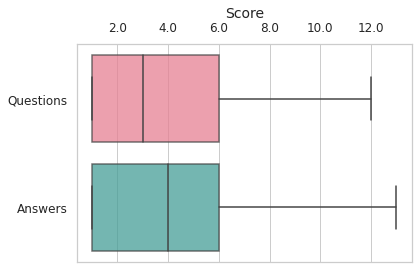

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter


sns.set(style="whitegrid")

# Plot boxplot for the distributions of dates of the used posts (Unique questions + all answers)
# Color vaiant "muted"
fig = sns.boxplot(y= 'boxPlot', x = 'Score', data = box_plot, showfliers=False, palette="husl", boxprops=dict(alpha=.75))
fig.xaxis.set_label_position('top')
fig.set(ylabel = None)
fig.set_xlabel('Score', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
fig.xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

plt.show()

In [17]:
# PLot a histogram of the dates of the used posts (Unique questions + all answers)
dates_q = df_original_questions['Date'].values
dates_a = df_original_answers['Date'].values
dates = np.append(dates_q, dates_a, 0)


In [18]:
dates_q.shape, dates_a.shape, dates.shape

((111,), (121,), (232,))

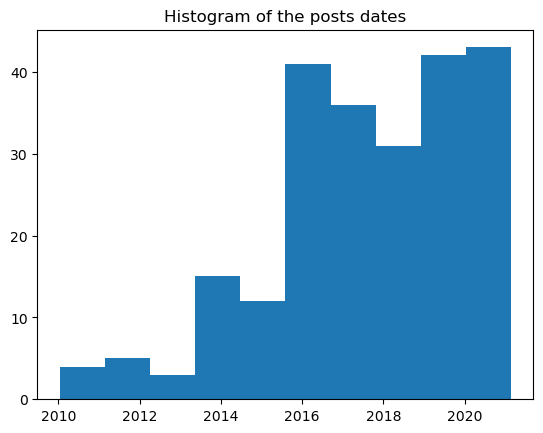

In [19]:
sns.reset_defaults()
_ = plt.hist(dates, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of the posts dates")
plt.show()